In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Building a Traffic Sign Recognition Classifier, Deep Learning Approach 

### Loading the Data 

> **Note**: In this project, I use deep neural networks and convolutional neural networks to classify traffic signsusing traffic signs from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). 

In [1]:
# Load pickled data
import pickle

import pandas as pd
import cv2
import numpy as np
from sklearn import preprocessing
import os
from random import shuffle
import glob
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from keras.layers import Input, InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import keras
from keras import backend as K

Using TensorFlow backend.


In [2]:
training_raw_file = "traffic-signs-data/train.p"
validation_raw_file = "traffic-signs-data/valid.p"
testing_raw_file = "traffic-signs-data/test.p"

training_processed_file = "traffic-signs-data/train-processed.p"
validation_processed_file = "traffic-signs-data/valid-processed.p"
testing_processed_file = "traffic-signs-data/test-processed.p"

csv_features_file = "signnames.csv"

### Creating pre-processed data files  

> **None**: Run this cell only to create the pre-processed data files. If the files are already created, you should skip running this cell again.

1. **Whitening the images** , following the instructions provided in the link below:  

  - [LINK-1: Preprocessing for deep learning: from covariance matrix to image whitening](https://hadrienj.github.io/posts/Preprocessing-for-deep-learning/)
  - [LINK-2: Preprocessing for deep learning: from covariance matrix to image whitening](https://www.freecodecamp.org/news/preprocessing-for-deep-learning-from-covariance-matrix-to-image-whitening-9e2b9c75165c/)
    
2. **General preprocessing proposals**  

  - [Image Pre-processing for Deep Learning](https://towardsdatascience.com/image-pre-processing-c1aec0be3edf) 


In [8]:
from importlib import reload
import classificationModules
reload(classificationModules)
from classificationModules import Cnn

# in case resizing is required - not used in this pipeline
target_image_size = 32
epsilon = 0.0

with open(training_raw_file, mode="rb") as f:
    train_raw_data = pickle.load(f)
with open(validation_raw_file, mode="rb") as f:
    valid_raw_data = pickle.load(f)
with open(testing_raw_file, mode="rb") as f:
    test_raw_data = pickle.load(f)

# pre-processing the raw data 

x_train_raw_data, y_train_raw_data = train_raw_data["features"], train_raw_data["labels"]
x_valid_raw_data, y_valid_raw_data = valid_raw_data["features"], valid_raw_data["labels"]
x_test_raw_data, y_test_raw_data = test_raw_data["features"], test_raw_data["labels"]

x_train_norm_data = Cnn.normalize(x_train_raw_data, approach="scale")
x_valid_norm_data = Cnn.normalize(x_valid_raw_data, approach="scale")
x_test_norm_data = Cnn.normalize(x_test_raw_data, approach="scale")

# unique_label_ids = np.unique(train_raw_data["labels"])

# features_counts = [(np.where(train_raw_data["labels"] == label_id))[0].size for label_id in unique_label_ids]
# print("Features Count:\n", features_counts)
# min_features_counts = min(features_counts)

y_train_norm_data = y_train_raw_data

x_train_norm_data, y_train_norm_data, features_counts = Cnn.augment_data(x_train_norm_data, y_train_norm_data, epsilon=0.05)
x_train_norm_data, y_train_norm_data, features_counts = Cnn.augment_data(x_train_norm_data, y_train_norm_data, epsilon=-0.05)
x_train_norm_data, y_train_norm_data, features_counts = Cnn.augment_data(x_train_norm_data, y_train_norm_data, epsilon=0.05)

# arg_sort_indices = np.argsort(y_train_norm_data)
# x_train_norm_data = x_train_norm_data[arg_sort_indices]
# y_train_norm_data = y_train_norm_data[arg_sort_indices]

# x_train_norm_data, y_train_raw_data = Cnn.augment_data(x_train_norm_data, y_train_raw_data, epsilon=0.5)
# x_train_norm_data, y_train_raw_data = Cnn.augment_data(x_train_norm_data, y_train_raw_data, epsilon=0.8)

# Cnn.whiten_images_zca(x_train_norm_data, train_processed_data["features"], batch_size=1000, epsilon=0.1)
# Cnn.whiten_images_zca(x_valid_norm_data, valid_processed_data["features"], batch_size=1000, epsilon=0.1)
# Cnn.whiten_images_zca(x_test_norm_data, test_processed_data["features"], batch_size=1000, epsilon=0.1)

# np.zeros_like(x_train_norm_data).astype(np.uint8)
train_processed_data = {"features":None, "labels":y_train_norm_data}
valid_processed_data = {"features":None, "labels":y_valid_raw_data}
test_processed_data = {"features":None, "labels":y_test_raw_data}

train_processed_data["features"] = Cnn.whiten_images_self_mean(x_train_norm_data, batch_size=1000, width_offset=1, height_offset=1, 
                                                               epsilon=0.0, verbose=True)
valid_processed_data["features"] = Cnn.whiten_images_self_mean(x_valid_norm_data, batch_size=1000, width_offset=1, height_offset=1, 
                                                               epsilon=0.0, verbose=True)
test_processed_data["features"] = Cnn.whiten_images_self_mean(x_test_norm_data, batch_size=1000, width_offset=1, height_offset=1, 
                                                              epsilon=0.0, verbose=True)

# train_processed_data = np.copy(train_raw_data)
# valid_processed_data = np.copy(valid_raw_data)
# test_processed_data = np.copy(test_raw_data)

with open(training_processed_file, mode="wb") as f:
    pickle.dump(train_processed_data, f)
with open(validation_processed_file, mode="wb") as f:
    pickle.dump(valid_processed_data, f)
with open(testing_processed_file, mode="wb") as f:
    pickle.dump(test_processed_data, f)

# releasing memory 

train_raw_data = None
valid_raw_data = None
test_raw_data = None

train_processed_data = None
valid_processed_data = None
test_processed_data = None


features count before augmentation: [ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920
  690  540  360  990 1080  180  300  270  330  450  240 1350  540  210
  480  240  390  690  210  599  360 1080  330  180 1860  270  300  210
  210]
features count after augmentation: [360, 2160, 2190, 1440, 1950, 1830, 540, 1470, 1440, 1500, 1980, 1350, 2070, 2100, 870, 720, 540, 1170, 1260, 360, 480, 450, 510, 630, 420, 1530, 720, 390, 660, 420, 570, 870, 390, 779, 540, 1260, 510, 360, 2040, 450, 480, 390, 390]
features count before augmentation: [ 360 2160 2190 1440 1950 1830  540 1470 1440 1500 1980 1350 2070 2100
  870  720  540 1170 1260  360  480  450  510  630  420 1530  720  390
  660  420  570  870  390  779  540 1260  510  360 2040  450  480  390
  390]
features count after augmentation: [720, 2520, 2550, 1800, 2310, 2190, 900, 1830, 1800, 1860, 2340, 1710, 2430, 2460, 1230, 1080, 900, 1530, 1620, 720, 840, 810, 870, 990, 780, 1890, 1080, 750, 1020, 780, 930, 1230, 750,

In [4]:
print(train_raw_data["features"].shape, train_raw_data["labels"].shape)
print(train_processed_data["features"].shape, train_processed_data["labels"].shape)

temp_images = train_processed_data["features"]
temp_labels = train_processed_data["labels"]

#Cnn.plot_flattened_image(train_processed_data["features"][400])

indexxx = 1440

print(train_processed_data["labels"][indexxx].astype(np.uint8))
# print(train_processed_data["labels"][max(indexxx - 180, 0)].astype(np.uint8))

plt.figure(figsize=(1.5, 1.5))
plt.imshow(temp_images[indexxx])

# plt.figure(figsize=(1.5, 1.5))
# plt.imshow(temp_images[abs(indexxx - 180)])

# plt.figure(figsize=(1.5, 1.5))
# plt.imshow(x_train_raw_data[indexxx])

NameError: name 'train_raw_data' is not defined

### Loading data sets from the pickle files 
- In this cell, already-preprocessed data files are loaded for training, validation, and test purposes.  


### Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [3]:
with open(training_processed_file, mode="rb") as f:
    train_data = pickle.load(f)
with open(validation_processed_file, mode="rb") as f:
    valid_data = pickle.load(f)
with open(testing_processed_file, mode="rb") as f:
    test_data = pickle.load(f)

"""
with open(training_raw_file, mode="rb") as f:
    train_data = pickle.load(f)
with open(validation_raw_file, mode="rb") as f:
    valid_data = pickle.load(f)
with open(testing_raw_file, mode="rb") as f:
    test_data = pickle.load(f)
"""


'\nwith open(training_raw_file, mode="rb") as f:\n    train_data = pickle.load(f)\nwith open(validation_raw_file, mode="rb") as f:\n    valid_data = pickle.load(f)\nwith open(testing_raw_file, mode="rb") as f:\n    test_data = pickle.load(f)\n'

In [5]:
from importlib import reload
import classificationModules
reload(classificationModules)
from classificationModules import Cnn

In [6]:
x_train_raw_data, y_train_raw_data = train_data["features"], train_data["labels"]
x_valid_raw_data, y_valid_raw_data = valid_data["features"], valid_data["labels"]
x_test_raw_data, y_test_raw_data = test_data["features"], test_data["labels"]

# in case resizing is required - not used in this pipeline
target_image_size = 32
    
features_df = pd.read_csv(csv_features_file)
unique_label_ids = [row["ClassId"] for _, row in features_df.iterrows()]
unique_label_names = [row["SignName"] for _, row in features_df.iterrows()]

n_train = x_train_raw_data.shape[0]
n_validation = x_valid_raw_data.shape[0]
n_test = x_test_raw_data.shape[0]

# shape of an traffic sign image
image_shape = x_train_raw_data.shape[1:4]

# unique classes/labels there are in the dataset
assert np.array_equal(np.sort(np.unique(y_train_raw_data)), np.sort(np.asarray(unique_label_ids))), \
    "There is a mismatch in the training data"

n_classes = len(unique_label_ids)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# n_classes = len(cnn.label_ids)

features_counts = [(np.where(train_data["labels"] == label_id))[0].size for label_id in unique_label_ids]
print("\nFeatures count of training set\n:", features_counts)
print("\nFeatures count of validation set\n:", [(np.where(valid_data["labels"] == label_id))[0].size for label_id in unique_label_ids])
print("\nFeatures count of test set\n:", [(np.where(test_data["labels"] == label_id))[0].size for label_id in unique_label_ids])

print("")

# Preparing training and validation data set for labels 0 to 8 
filter_label_ids = np.linspace(0, 8, 9).astype(np.uint8)

unique_label_ids = filter_label_ids.copy()
# unique_label_names = [row["SignName"] for _, row in features_df.iterrows()]
n_classes = filter_label_ids.size

x_train_filtered_raw_data_1, y_train_filtered_raw_data_1, features_counts = \
    Cnn.get_features_of_types(x_train_raw_data, y_train_raw_data, filter_label_ids)

x_valid_filtered_raw_data_1, y_valid_filtered_raw_data_1, features_counts = \
    Cnn.get_features_of_types(x_valid_raw_data, y_valid_raw_data, filter_label_ids)

x_train_raw_data_1, y_train_raw_data_1, new_features_counts = \
    Cnn.select_equally_sized_data_sets(x_train_filtered_raw_data, y_train_filtered_raw_data, n_classes=n_classes, 
                                       unique_label_ids=None, features_counts=None)

x_valid_raw_data_1, y_valid_raw_data_1 = x_valid_filtered_raw_data_1, y_valid_filtered_raw_data_1

print("New Features Count:\n", new_features_counts)

print("\n  *** After Filtering Features ***")
print("Number of classes =", n_classes)

# Preparing training and validation data set for labels 9 to 42 



Number of training examples = 88979
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43

Features count of training set
: [1440, 3240, 3270, 2520, 3030, 2910, 1620, 2550, 2520, 2580, 3060, 2430, 3150, 3180, 1950, 1800, 1620, 2250, 2340, 1440, 1560, 1530, 1590, 1710, 1500, 2610, 1800, 1470, 1740, 1500, 1650, 1950, 1470, 1859, 1620, 2340, 1590, 1440, 3120, 1530, 1560, 1470, 1470]

Features count of validation set
: [30, 240, 240, 150, 210, 210, 60, 150, 150, 150, 210, 150, 210, 240, 90, 90, 60, 120, 120, 30, 60, 60, 60, 60, 30, 150, 60, 30, 60, 30, 60, 90, 30, 90, 60, 120, 60, 30, 210, 30, 60, 30, 30]

Features count of test set
: [60, 720, 750, 450, 660, 630, 150, 450, 450, 480, 660, 420, 690, 720, 270, 210, 150, 360, 390, 60, 90, 90, 120, 150, 90, 480, 180, 60, 150, 90, 150, 270, 60, 210, 120, 390, 120, 60, 690, 90, 90, 60, 90]

New Features Count:
 [1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440]

  *** After Filtering Features ***
Number of 

### Pre-processing loaded data  
- Normalization of loaded data between 0 and 1 
- One-hot encoding of the loaded labels 

In [7]:
import random

from importlib import reload
import classificationModules
reload(classificationModules)
from classificationModules import Cnn

cnn = Cnn()
cnn.init_model(unique_label_names, unique_label_ids)

x_train_data, y_train_data = Cnn.normalize(x_train_raw_data, approach="scale"), cnn.one_hot_encode(y_train_raw_data)
x_valid_data, y_valid_data = Cnn.normalize(x_valid_raw_data, approach="scale"), cnn.one_hot_encode(y_valid_raw_data)
x_test_data, y_test_data = Cnn.normalize(x_test_raw_data, approach="scale"), cnn.one_hot_encode(y_test_raw_data)


### Shuffle the traning data

In [8]:
labelled_data = list(zip(x_train_data, y_train_data))
random.shuffle(labelled_data)
random_x_train_data, random_y_train_data = zip(*labelled_data)

random_x_train_data = list(random_x_train_data)
random_y_train_data = list(random_y_train_data)

#print(random_y_train_data[0])
#print(random_x_train_data[0].shape)
#plt.imshow(random_x_train_data[0])

### Exploring and visualizing the dataset

In [9]:
%matplotlib inline

# cnn.display_images(random_x_train_data[0:10], random_y_train_data[0:10], normalized=True)
# cnn.display_images(x_valid_data[100:120], y_valid_data[100:120], normalized=True)

### Model Architecture

In [10]:
from importlib import reload
import classificationModules
reload(classificationModules)
from classificationModules import Cnn

cnn = Cnn()
cnn.init_model(unique_label_names, unique_label_ids)

In [11]:
def create_conv_net(x, keep_prob, n_classes):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data - normalized image 
    : keep_prob: Placeholder tensor that hold dropout keep probability 
    : return: Tensor that represents logits
    """
    # Applying a few Convolution and Max Pool layers
    
    conv_ksize = (8, 8)  # filter dimensions
    # conv_ksize = (3, 3)  # filter dimensions
    conv_strides = (1, 1)
    pool_ksize = (2, 2)  # Filter kernel/patch dimensions [batch, height, width, channels]
    pool_strides = (1, 1)
    
    # batch_normalizer = tf.keras.layers.BatchNormalization(trainable=False)
    # x = batch_normalizer(x)
    
    # batch_normalizer = None
    
    #conv_layer = conv2d_maxpool(x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv_num_outputs = 16  # D_out : number of out filters
    batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    conv_layer = cnn.conv2d_maxpool(x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
                                    wieghts_name="weights-layer-1", layer_name="hidden-layer-1", batch_normalizer=batch_normalizer)
    #conv_layer = normalize_batch(conv_layer)
    
    # next layer
    conv_ksize = (5, 5)  # output layers dimensions
    conv_num_outputs = 32
    batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    conv_layer = cnn.conv2d_maxpool(conv_layer, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
                                    wieghts_name="weights-layer-2", layer_name="hidden-layer-2", batch_normalizer=batch_normalizer)
    
    # next layer
    conv_ksize = (5, 5)  # output layers dimensions
    conv_num_outputs = 32
    batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    conv_layer = cnn.conv2d_maxpool(conv_layer, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
                                    wieghts_name="weights-layer-2", layer_name="hidden-layer-2", batch_normalizer=batch_normalizer)
    
    # next layer
    conv_ksize = (5, 5)  # output layers dimensions
    conv_num_outputs = 64
    batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    conv_layer = cnn.conv2d_maxpool(conv_layer, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
                                    wieghts_name="weights-layer-3", layer_name="hidden-layer-3", batch_normalizer=batch_normalizer)
    
    # next layer
    conv_ksize = (5, 5)  # output layers dimensions
    conv_num_outputs = 64
    batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    conv_layer = cnn.conv2d_maxpool(conv_layer, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
                                    wieghts_name="weights-layer-4", layer_name="hidden-layer-4", batch_normalizer=batch_normalizer)
    
    # next layer
    conv_ksize = (2, 2)  # output layers dimensions
    conv_num_outputs = 128
    batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    conv_layer = cnn.conv2d_maxpool(conv_layer, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
                                    wieghts_name="weights-layer-5", layer_name="hidden-layer-5", batch_normalizer=batch_normalizer)
    
    # next layer
    # conv_ksize = (1, 1)  # output layers dimensions
    # conv_num_outputs = 256
    # batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    # conv_layer = cnn.conv2d_maxpool(conv_layer, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
    #                                 wieghts_name="weights-layer-4", layer_name="hidden-layer-4", batch_normalizer=batch_normalizer)
    
    # next layer
    # conv_ksize = (1, 1)  # output layers dimensions
    # conv_num_outputs = 512
    # batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    # conv_layer = cnn.conv2d_maxpool(x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
    #                                 wieghts_name="weights-layer-5", layer_name="hidden-layer-5", batch_normalizer=batch_normalizer)

    ################################################
    # flattenning the layer
    x_tensor = cnn.flatten(conv_layer)

    # Applying a few fully connected layers
    
    # x_tensor = tf.layers.batch_normalization(x_tensor)
    x_tensor = cnn.fully_conn(x_tensor, 128)
    # normalize_batch = tf.keras.layers.BatchNormalization(trainable=True)
    # x_tensor = normalize_batch(x_tensor)
    x_tensor = tf.nn.dropout(x_tensor, keep_prob)
    
    x_tensor = cnn.fully_conn(x_tensor, 64)
    # normalize_batch = tf.keras.layers.BatchNormalization(trainable=True)
    # x_tensor = normalize_batch(x_tensor)
    x_tensor = tf.nn.dropout(x_tensor, keep_prob)

    #x_tensor = cnn.fully_conn(x_tensor, 128)
    # normalize_batch = tf.keras.layers.BatchNormalization(trainable=True)
    # x_tensor = normalize_batch(x_tensor)
    #x_tensor = tf.nn.dropout(x_tensor, keep_prob)

    # x_tensor = tf.layers.batch_normalization(x_tensor)
    #x_tensor = cnn.fully_conn(x_tensor, 32)
    #normalize_batch = tf.keras.layers.BatchNormalization(trainable=True)
    #x_tensor = normalize_batch(x_tensor)
    #x_tensor = tf.nn.dropout(x_tensor, keep_prob)

    # Applying an Output Layer
    output_tensor = cnn.output(x_tensor, n_classes)
    
    return output_tensor


##############################
## Build the Neural Network ##
##############################

learning_rate = 1e-4

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = cnn.neural_net_image_input((target_image_size, target_image_size, 3))
y = cnn.neural_net_label_input(n_classes)
keep_prob = cnn.neural_net_keep_prob_input()

# Model
logits = create_conv_net(x, keep_prob, n_classes)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name="logits")

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name="accuracy")

# tests.test_conv_net(conv_net)

conv2d_maxpool... Start
Checking inputs dimensions...
conv_ksize: (8, 8)
conv_num_outputs: 16
Instructions for updating:
Colocations handled automatically by placer.
Checking strides dimensions...
conv_strides: (1, 1, 1, 1)
pool_ksize: (1, 2, 2, 1)
pool_strides (1, 1, 1, 1)
batch_normalizer: <tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x000001AD17650E80>
conv_layer: (?, 24, 24, 16)
conv2d_maxpool... End

conv2d_maxpool... Start
Checking inputs dimensions...
conv_ksize: (5, 5)
conv_num_outputs: 32
Checking strides dimensions...
conv_strides: (1, 1, 1, 1)
pool_ksize: (1, 2, 2, 1)
pool_strides (1, 1, 1, 1)
batch_normalizer: <tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x000001AD17650F60>
conv_layer: (?, 19, 19, 32)
conv2d_maxpool... End

conv2d_maxpool... Start
Checking inputs dimensions...
conv_ksize: (5, 5)
conv_num_outputs: 32
Checking strides dimensions...
conv_strides: (1, 1, 1, 1)
pool_ksize: (1, 2, 2, 1)
pool_strides 

### Setting up hyper parameters and training on batches

In [13]:
epochs = 50
batch_size = 128
keep_probability = 0.80
save_model_path = "saved-model-01/"

In [ ]:
print("Training... start")

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        
        # for batch_features, batch_labels in CommonModules.load_preprocess_training_batch(batch_i, batch_size):
        for batch_features, batch_labels in cnn.batch_features_labels(random_x_train_data, random_y_train_data, batch_size):
            
            # print(batch_features.shape)
            # print(batch_labels.shape)
            
            cnn.train_neural_network(sess, x, y, keep_prob, optimizer, keep_probability, batch_features, batch_labels)
            
        # print("Epoch {0:>2}: ".format(epoch + 1))
        
        cnn.print_stats(sess, x, y, keep_prob, batch_features, batch_labels, x_valid_data, y_valid_data, cost, accuracy, "Epoch {0:>2}: ".format(epoch + 1))
        
        if((epoch + 1) % 1 == 0):
            print("")
    
    # Save the Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

print("Training... end")

Training... start
Epoch  1: Test Cost: 1.1167   ---   Valid Accuracy: 0.6493
Epoch  2: Test Cost: 0.5100   ---   Valid Accuracy: 0.8903
Epoch  3: Test Cost: 0.2116   ---   Valid Accuracy: 0.9382
Epoch  4: Test Cost: 0.1340   ---   Valid Accuracy: 0.9674
Epoch  5: Test Cost: 0.0912   ---   Valid Accuracy: 0.9688
Epoch  6: Test Cost: 0.0807   ---   Valid Accuracy: 0.9819
Epoch  7: Test Cost: 0.0976   ---   Valid Accuracy: 0.9688
Epoch  8: Test Cost: 0.0802   ---   Valid Accuracy: 0.9743
Epoch  9: Test Cost: 0.0369   ---   Valid Accuracy: 0.9792
Epoch 10: Test Cost: 0.0213   ---   Valid Accuracy: 0.9729
Epoch 11: Test Cost: 0.0057   ---   Valid Accuracy: 0.9826
Epoch 12: Test Cost: 0.0152   ---   Valid Accuracy: 0.9819
Epoch 13: Test Cost: 0.0031   ---   Valid Accuracy: 0.9910
Epoch 14: Test Cost: 0.0022   ---   Valid Accuracy: 0.9799
Epoch 15: Test Cost: 0.0145   ---   Valid Accuracy: 0.9875
Epoch 16: Test Cost: 0.0070   ---   Valid Accuracy: 0.9896
Epoch 17: Test Cost: 0.0019   ---   Va

### Overfitting

Training... start  
Epoch 10: Test Cost: 0.1957   ---   Valid Accuracy: 0.8329 
Epoch 20: Test Cost: 0.0632   ---   Valid Accuracy: 0.8719  
Epoch 30: Test Cost: 0.0262   ---   Valid Accuracy: 0.8878  
Epoch 40: Test Cost: 0.0135   ---   Valid Accuracy: 0.8961  
Epoch 50: Test Cost: 0.0165   ---   Valid Accuracy: 0.8855  
Epoch 60: Test Cost: 0.0038   ---   Valid Accuracy: 0.8882  
Epoch 70: Test Cost: 0.0050   ---   Valid Accuracy: 0.8966  
Epoch 80: Test Cost: 0.0021   ---   Valid Accuracy: 0.8868  
Epoch 90: Test Cost: 0.0024   ---   Valid Accuracy: 0.8791  
Epoch 100: Test Cost: 0.0013   ---   Valid Accuracy: 0.8871  
Training... end  

In [18]:
import random

from importlib import reload
import classificationModules
reload(classificationModules)
from classificationModules import Cnn

cnn = Cnn()
cnn.init_model(unique_label_names, unique_label_ids)

In [19]:
fpr = {}
tpr = {}
auc = {}

INFO:tensorflow:Restoring parameters from saved-model/
Testing Accuracy: 0.890243513584137



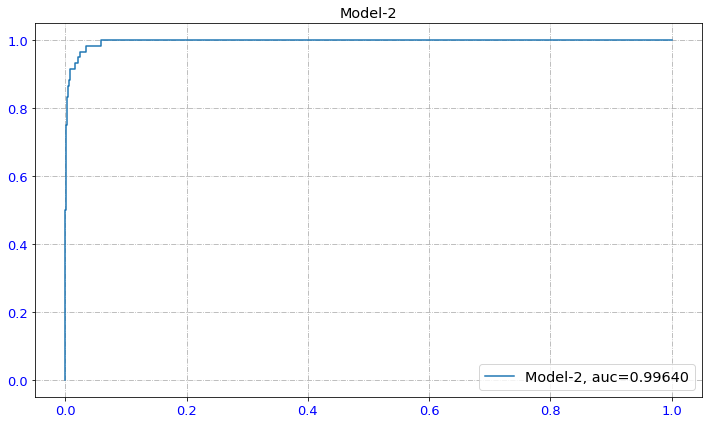

In [25]:
top_n_predictions = 3

def test_model(test_features, test_labels, n_classes, n_samples):
    """
    Test the saved model against the test dataset
    """

    # test_images, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()
    # loaded_graph = tf.get_default_graph()

    with tf.Session(graph=loaded_graph) as sess:
    # with tf.Session() as sess:
        # sess.run(tf.global_variables_initializer())
        
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + ".meta")
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name("x:0")
        loaded_y = loaded_graph.get_tensor_by_name("y:0")
        loaded_keep_prob = loaded_graph.get_tensor_by_name("keep_prob:0")
        loaded_logits = loaded_graph.get_tensor_by_name("logits:0")
        loaded_acc = loaded_graph.get_tensor_by_name("accuracy:0")
        
        # sess.run(tf.global_variables_initializer())
        
        # loaded_y = tf.expand_dims(loaded_y, 1)
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in cnn.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            
            test_batch_count += 1
            
        print("Testing Accuracy: {}\n".format(test_batch_acc_total/test_batch_count))

        # ROC
        #all_test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), label_categories_count), 
        #                                            feed_dict={loaded_x: test_features, loaded_y: test_labels, loaded_keep_prob: 1.0})
        
        all_test_predictions = sess.run(tf.nn.softmax(loaded_logits), 
                                        feed_dict={loaded_x: test_features, loaded_y: test_labels, loaded_keep_prob: 1.0})

        predicted_y_probabilities = (all_test_predictions / all_test_predictions.sum(axis=0, keepdims=1))[::, 0]

        #print("all_test_predictions", all_test_predictions[:10])
        #print("y_pred_proba", y_pred_proba[:10])

        #y_pred = all_test_predictions[1][::, 0]
        #y_pred_proba = (all_test_predictions[0] / all_test_predictions[0].sum(axis=0, keepdims=1))[::, 0]
        
        # print("y_pred_proba", y_pred_proba)
        
        fpr["model-a"], tpr["model-a"], auc["model-a"] = cnn.plot_roc_curve(test_labels[::, 0], predicted_y_probabilities, 
                                                                            title="Model-2", legend_title="Model-2, auc")
        
        #fpr, tpr, _ = metrics.roc_curve(test_labels[::, 0], predicted_y_probabilities)
        #auc = metrics.roc_auc_score(test_labels[::, 0], predicted_y_probabilities)
        #plt.plot(fpr,tpr,label="data 1, auc=" + str(auc))
        #plt.legend(loc=4)
        #plt.show()

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        # random_test_predictions = sess.run(tf.nn.softmax(loaded_logits),
        #                                   feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        
        #random_test_predictions = sess.run(tf.nn.top_k(random_test_predictions, label_categories_count))

        random_test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), n_classes), 
                                                       feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, 
                                                                  loaded_keep_prob: 1.0})
        
        # print("random_test_predictions", random_test_predictions.values[0])
        # print("random_test_labels", np.asanyarray(random_test_labels).shape)
        # print("random_test_labels", cnn.lb.inverse_transform(np.asanyarray(random_test_labels)))
        
        # random_test_predictions = sess.run(
        #  tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
        #  feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        # cnn.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)
        
    return (random_test_features, random_test_labels, random_test_predictions)
        
tested_features, tested_labels, tested_predictions = test_model(x_test_data, y_test_data, n_classes, n_samples=10)

In [37]:
%matplotlib inline

tested_label_ids = cnn.lb.inverse_transform(np.asanyarray(tested_labels))

print(tested_label_ids)
print(tested_predictions.values[:, :3])

# cnn.display_images(random_tested_features, random_tested_labels, normalized=True)

[10  4  4 10  4 19  1  0 38  1]
[[9.8949569e-01 5.6549874e-03 2.1259668e-03]
 [5.1303053e-01 4.8619887e-01 7.1128295e-04]
 [9.5947099e-01 3.5090934e-02 4.1949530e-03]
 [9.9995601e-01 3.6771096e-05 4.0885579e-06]
 [9.9757630e-01 2.3419736e-03 7.0862035e-05]
 [2.6593241e-01 1.3059227e-01 1.2550993e-01]
 [9.9473804e-01 3.1423117e-03 2.1135290e-03]
 [7.2206289e-01 2.7734289e-01 4.4745416e-04]
 [9.9998498e-01 1.3319583e-05 1.3948443e-06]
 [9.9997497e-01 2.4958326e-05 6.8830069e-08]]


In [40]:
tested_predictions.indices[:, 0]

array([10,  0,  4, 10,  8, 19,  1,  1, 38,  1])

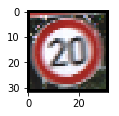

In [42]:
plt.figure(figsize=(1.5, 1.5))
plt.imshow(tested_features[7])

----

## Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

### Model Architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [1]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

## Building a Traffic Sign Recognition Classifier, Deep Learning Approach 

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

----

## Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.